In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

# Question 1

### Log-Likelihood & Log-Posterior Functions

The likelihood function for the GARCH model parameters $\omega_1, \omega_2, \omega_3$ given returns $r$ is defined as:
$$
l(\omega_1, \omega_2, \omega_3 \mid r) \propto \prod_{t=1}^T h_t^{-\frac{1}{2}} \exp\left(-\frac{1}{2} \sum_{t=1}^T \frac{r_t^2}{h_t}\right)
$$

The posterior distribution, incorporating independent truncated Normal priors for the parameters, is given by:
$$
\pi(\omega_1, \omega_2, \omega_3 \mid r) \propto \exp\left(-\frac{1}{2} \left(\frac{\omega_1^2}{\sigma^2(\omega_1)} + \frac{\omega_2^2}{\sigma^2(\omega_2)} + \frac{\omega_3^2}{\sigma^2(\omega_3)}\right)\right) \prod_{t=1}^T h_t^{-\frac{1}{2}} \exp\left(-\frac{1}{2} \sum_{t=1}^T \frac{r_t^2}{h_t}\right)
$$

This gives us both the log-likelihood expression and the log-posterior expression:
$$
\log l(\omega_1, \omega_2, \omega_3 \mid r) = -\frac{1}{2} \sum_{t=1}^T \left( \log h_t + \frac{r_t^2}{h_t}\right)
$$

$$
\log \pi(\omega_1, \omega_2, \omega_3 \mid r) = -\frac{1}{2} \left(\frac{\omega_1^2}{\sigma^2(\omega_1)} + \frac{\omega_2^2}{\sigma^2(\omega_2)} + \frac{\omega_3^2}{\sigma^2(\omega_3)}\right) -\frac{1}{2} \sum_{t=1}^T \left( \log h_t + \frac{r_t^2}{h_t}\right)
$$


### Implement the RWMH Sampler

1. Follow the guidelines given in that experiment to implement a random walk Metropo-
lis sampler that targets the posterior distribution of a GARCH model. For the
data, you can use simulated data at first, and then look at the same type of real
data (log-returns computed from exchange rates) in a second time

In [2]:
def simulate_garch(T, omega_1, omega_2, omega_3):
    np.random.seed(423)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3)
    r[0] = np.random.normal(0, np.sqrt(h[0]))

    
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(h[t]))
        
    return r, h


In [3]:
def log_likelihood(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega_1 / (1 - omega_2 - omega_3) if (omega_2 + omega_3) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        log_lik -= 0.5 * (np.log(h[t]) + r[t]**2 / h[t])
    
    return log_lik

def log_posterior(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    log_prior = -0.5 * (omega_1**2 / sigma_1**2 + omega_2**2 / sigma_2**2 + omega_3**2 / sigma_3**2)
    return log_likelihood(r, omega_1, omega_2, omega_3) + log_prior

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new[0],omega_new[1],omega_new[2],sigma_omega[0],sigma_omega[1],sigma_omega[2]) - log_posterior(returns,omega[0],omega[1],omega[2],sigma_omega[0],sigma_omega[1],sigma_omega[2])
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

**Example on simulated data**

So we are going to test few things.
First, if we get metropolis_omega near of our initial_omega that gave the return.
 Secondly, we will check if the f_tilde function allows to reduce the variance of the estimators while keeping the same expected value
 Finally, we will check the unbiasedness of our estimators that has been proven in one of the article
 

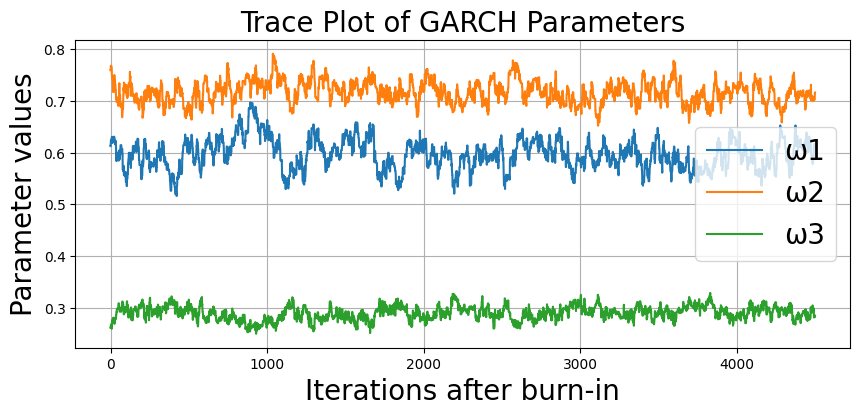

In [8]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors 

# Simulate data
returns, _ = simulate_garch(10000, *true_omega)

# Metropolis-Hastings settings
iterations = 5000
burn_in = 500
sigma_proposal = 0.01 

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()

In [18]:
print(f"omega_1 initial: {w1_samples[1]}")
print(w2_samples[1])
print(w3_samples[3])

omega_1 initial: 0.3
0.3
0.3


As previously discussed, we expect that 
$$\frac{1}{n}\sum_{i=1}^n f(X_i) \to \int f \, d\pi \quad \text{almost surely as } n \to \infty.$$ 
In this instance, we define the identity function as $f$: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$. Consequently, we will verify whether the empirical means of these three sequences approach the actual values of the parameters $\omega_1$, $\omega_2$, and $\omega_3$.

In [9]:
# Computing the average values post burn-in
expected_w1 = np.average(w1_samples[burn_in:])
expected_w2 = np.average(w2_samples[burn_in:])
expected_w3 = np.average(w3_samples[burn_in:])

# Display the calculated mean values
print("Calculated Mean Values:")
print(f"Expected ω1: {expected_w1}")
print(f"Expected ω2: {expected_w2}")
print(f"Expected ω3: {expected_w3}")

Calculated Mean Values:
Expected ω1: 0.5965126686966019
Expected ω2: 0.7170730425121103
Expected ω3: 0.2897041820376045


Our $\omega_1,\omega_2,\omega_3$ implemented in the garch_simulation were : $[0.6, 0.7, 0.3]$, therefore we have almost the same figures which means that our algorithm works well.

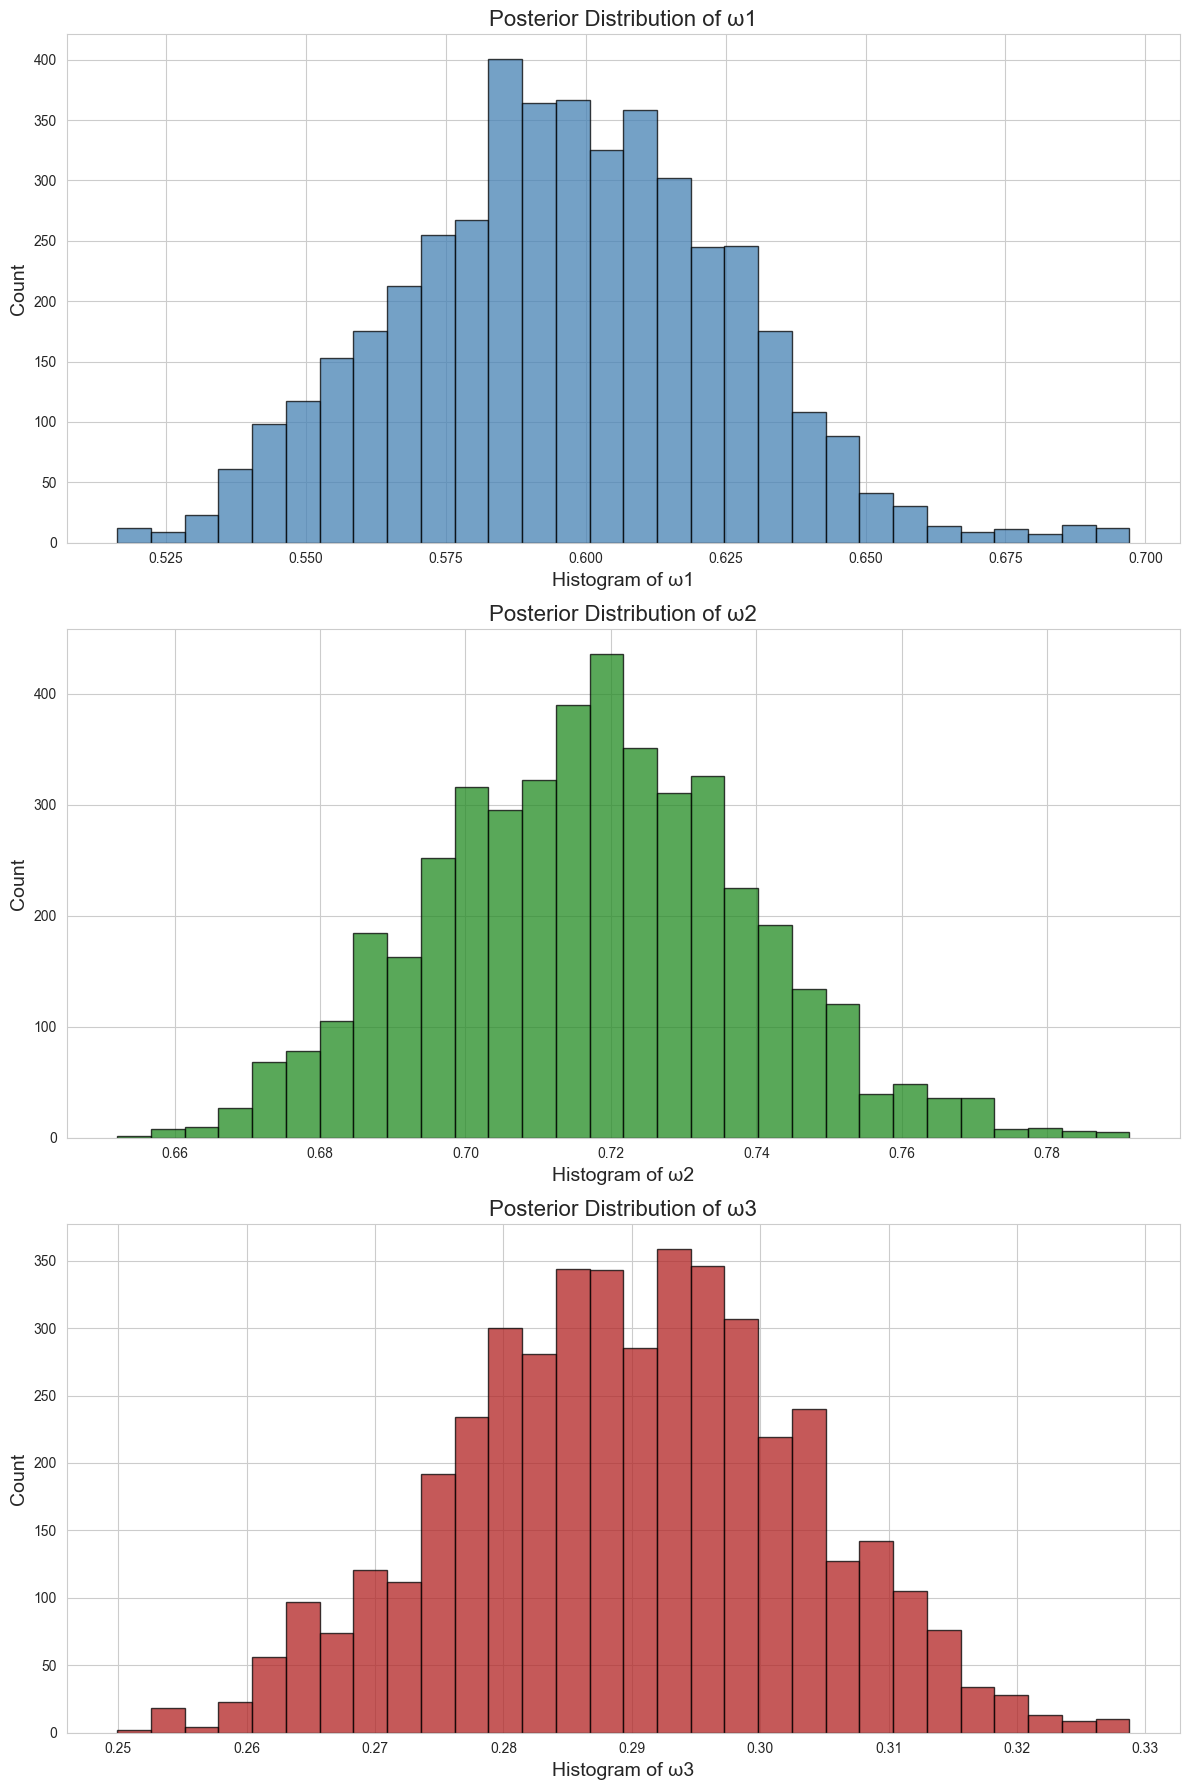

In [22]:
# Apply a seaborn style to enhance aesthetics
sns.set_style("whitegrid")

fig, axs = plt.subplots(3, figsize=(12, 18))

# Function to plot a histogram with matplotlib, with enhanced presentation
def custom_hist(data, bins, color, label, ax):
    counts, edges, _ = ax.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.75)
    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    return counts, edges

# Plot histograms with detailed customization
_, edges1 = custom_hist(w1_samples[burn_in:], 30, 'steelblue', 'Histogram of ω1', axs[0])
axs[0].set_title('Posterior Distribution of ω1', fontsize=16)

_, edges2 = custom_hist(w2_samples[burn_in:], 30, 'forestgreen', 'Histogram of ω2', axs[1])
axs[1].set_title('Posterior Distribution of ω2', fontsize=16)

_, edges3 = custom_hist(w3_samples[burn_in:], 30, 'firebrick', 'Histogram of ω3', axs[2])
axs[2].set_title('Posterior Distribution of ω3', fontsize=16)

# Fine-tuning the plot layout
plt.tight_layout()
plt.show()

We can see that these histograms of the posterior distribution of $\omega_1,\omega_2,\omega_3$ are almost histograms from normal distribution. However, they are not perfectly centered with the empirical expected value of omega but they are indeed near of them. We could also see it with boxplot.

In [23]:
# We are now doing to develop a function that will iterate the metropolis_hasting_algorithm in order to make statistical test and study on the distributions of the omega

def mean_metropolis_algorithm(iterations1):
    expected_w1_list = []
    expected_w2_list = []
    expected_w3_list = []
    for i in range(iterations1):
        results = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

        # Check if results structure is as expected
        if not isinstance(results, tuple) or len(results) < 2:
            raise ValueError("The results from the Metropolis-Hasting algorithm do not match the expected format.")

        omega_samples = results[1]  # Assuming the second item is the list of omega samples

        # Prepare lists to hold the current iteration values for w1, w2, w3
        w1_samples = []
        w2_samples = []
        w3_samples = []

        # Extract samples depending on whether they are scalar or array-like
        for sample in omega_samples:
            if np.isscalar(sample):  # Handling cases where the sample might be a single scalar value
                w1_samples.append(sample)  # Assuming scalar results pertain to w1 or need clarification on which omega they relate to
            else:  # Otherwise, handle as arrays
                w1_samples.append(sample[0])
                w2_samples.append(sample[1])
                w3_samples.append(sample[2])

        # Calculate means after burn-in period
        w1_expected = np.mean(w1_samples[burn_in:])
        w2_expected = np.mean(w2_samples[burn_in:])
        w3_expected = np.mean(w3_samples[burn_in:])
        
        expected_w1_list.append(w1_expected)
        expected_w2_list.append(w2_expected)
        expected_w3_list.append(w3_expected)
        
    return [expected_w1_list, expected_w2_list, expected_w3_list]

Example on real date (exchange rate like on the first article on zero variance)

In [11]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns, _ = simulate_garch(900, *true_omega)

# Metropolis-Hastings settings
iterations = 3000 # less iterations than before
burn_in = 300 # smaller burn_in too
sigma_proposal = 0.01


In [12]:
mean_met_alg = mean_metropolis_algorithm(10)

In [13]:
print(mean_met_alg)

[[0.6116491386247296, 0.5993130729631241, 0.5462929629809434, 0.5744445146086531, 0.5664165056156716, 0.5709260485612353, 0.5638615396755638, 0.5737691300812786, 0.5929858716559766, 0.5690610360414491], [0.6060660774961191, 0.6246585077409983, 0.6129158483686351, 0.6062577103272443, 0.6301152858867707, 0.5954178853415766, 0.6248695687766227, 0.6176730006833375, 0.6161460694104786, 0.6037618380425405], [0.33091923651448774, 0.33104298451925135, 0.34081689529909837, 0.33783843571333527, 0.33280379120579684, 0.3465618010006526, 0.33311772852893584, 0.3362164951173019, 0.3274235048360092, 0.34190379348856287]]


In [14]:
# So now, as we said before we are going to check if the f_tilde function allows to reduce the variance of the estimators while keeping the same expected value
# Thanks to the mean_metropolis_algorithm we can get the variance of our estimators

def variance_estimators(mean_met_alg):
    return statistics.variance(mean_met_alg[0]), statistics.variance(mean_met_alg[1]), statistics.variance(mean_met_alg[2])

# So the variance without the method used in the article is 

print("The variance without the method used in the article is:")
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg)}")

# We will see the variance reduction in the next questions

# Now, let's check the unbiasedness of our estimators that has been proven in one of the article.

def bias_estimators(mean_met_alg):
    return statistics.mean(mean_met_alg[0]) - true_omega[0], statistics.mean(mean_met_alg[1]) - true_omega[1], statistics.mean(mean_met_alg[2]) - true_omega[2]

print(f"The bias of the estimators are : {bias_estimators(mean_met_alg)}")

# There is still some bias but it is very small and it may be explicated by the few numbers of iterations of the metropolis_hasting_algorithm, so like it was said in the paper, there is the unbiasedness of the estimators

# To end this part we can finally check the mean squared error of the estimators

mse = {}

# We calculate the MSE for each parameter
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg[i-1]])

print(mse)

# The mse for both parameters are very small.

The variance without the method used in the article is:
Variance de ω1,w2,w3 : (0.0003664734350689903, 0.00012036468057777299, 3.503528779531747e-05)
The bias of the estimators are : (-0.023128017919137434, -0.08621182079256762, 0.035864466622343216)
{1: 0.0008647313044300346, 2: 0.007540806256889792, 3: 0.0013177917251209555}


**Let's do the example on real data as it is asked in the end of the first question**

In [15]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [18]:
from lxml import etree
import requests
import pandas as pd

def fetch_ecb_data(series_id, start_date, end_date):
    # Define the URL template for accessing ECB data
    url = f"https://sdw-wsrest.ecb.europa.eu/service/data/EXR/D.{series_id}.EUR.SP00.A"

    # Set up headers to specify the desired response format as 'generic' XML
    headers = {
        'Accept': 'text/xml'
    }
    params = {
        'startPeriod': start_date,
        'endPeriod': end_date
    }
    response = requests.get(url, headers=headers, params=params)

    # We parse the XML response
    root = etree.fromstring(response.content)
    ns = {'ns': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message',
          'common': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common',
          'generic': 'http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic'}

    # Then we extract data points
    data = []
    for series in root.xpath('.//generic:Series', namespaces=ns):
        for obs in series.xpath('.//generic:Obs', namespaces=ns):
            time = obs.find('.//generic:ObsDimension', namespaces=ns).get('value')
            value = obs.find('.//generic:ObsValue', namespaces=ns).get('value')
            data.append({'Date': time, 'Rate': value})

    # Convert list of dictionaries into a DataFrame
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])
    df['rate'] = pd.to_numeric(df['Rate'], errors='coerce')
    return df

In [19]:
# We will use EUR to GBP exchanges rates on the year 2019 to 2022:
df = fetch_ecb_data('GBP', '2019-01-01', '2022-12-31')
df.head()

,Date,Rate,rate
0,2019-01-02,0.90165,0.90165
1,2019-01-03,0.90312,0.90312
2,2019-01-04,0.89988,0.89988
3,2019-01-07,0.8972,0.89720
4,2019-01-08,0.89743,0.89743


In [20]:
df["rate"] = (df["rate"] - df["rate"].shift(1)) / df["rate"].shift(1)
df = df.dropna()
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['rate'])
df['rate'] = df['rate'].interpolate() # for the missing values
rates = df["rate"].to_numpy()*100



In [21]:
rates

array([ 0.16303444, -0.35875631, -0.29781749, ..., -0.31132193,
        0.55758704,  0.16262183])

In [22]:
pip install arch

Note: you may need to restart the kernel to use updated packages.


In [23]:
# We will do the same as in the first part of the question with simulated data, we will compare the garch model with the metropolis_hasting samplings

# We fit a garch model with our real datas :
import arch
real_garch = arch.arch_model(rates, vol = 'GARCH', p=1, q=1) # GARCH(1,1)

real_garch = real_garch.fit()

print(real_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 468895.5390594251
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1630995142.1371253
Iteration:      3,   Func. Count:     23,   Neg. LLF: 662.8133416047322
Iteration:      4,   Func. Count:     30,   Neg. LLF: 664.4964495261827
Iteration:      5,   Func. Count:     36,   Neg. LLF: 613.0055477032379
Iteration:      6,   Func. Count:     41,   Neg. LLF: 613.003737194661
Iteration:      7,   Func. Count:     46,   Neg. LLF: 613.0008022334438
Iteration:      8,   Func. Count:     51,   Neg. LLF: 613.0007752881918
Iteration:      9,   Func. Count:     56,   Neg. LLF: 613.0007707085082
Iteration:     10,   Func. Count:     60,   Neg. LLF: 613.0007707085272
Optimization terminated successfully    (Exit mode 0)
            Current function value: 613.0007707085082
            Iterations: 10
            Function evaluations: 60
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results               

In [2]:
# Now we use our metropolis_hasting_algorithm with our real data, we use the same parameters as for the simulated data : ( the same thing as for simulated data)

# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.0368,0.6921,0.1308] # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns = rates

# Metropolis-Hastings settings
iterations = 5000
burn_in = 500
sigma_proposal = 0.01

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

# We plot the parameter trajectories
plt.figure(figsize=(10, 4))
plt.plot(w1_samples[burn_in:], label='ω1')
plt.plot(w2_samples[burn_in:], label='ω2')
plt.plot(w3_samples[burn_in:], label='ω3')
plt.legend(fontsize=20)
plt.xlabel('Iterations after burn-in', fontsize=20)
plt.ylabel('Parameter values', fontsize=20)
plt.title('Trace Plot of GARCH Parameters', fontsize=20)
plt.grid(True)
plt.show()


NameError: name 'rates' is not defined

In [ ]:
mean_met_alg2 = mean_metropolis_algorithm(10)

/var/folders/dl/gt7zs7yx47xdn1_hyjv5m3tc0000gn/T/ipykernel_77576/1575354758.py:9: RuntimeWarning: invalid value encountered in log
  log_lik -= 0.5 * (np.log(h[t]) + r[t]**2 / h[t])


KeyboardInterrupt: 

In [ ]:
# Let's reuse the function we have implemented for the simulated datas :

# Variance
print(f"Variance de ω1,w2,w3 : {variance_estimators(mean_met_alg2)}")
# Bias
print(f"The bias of the estimators are : {bias_estimators(mean_met_alg2)}")
# MSE
mse = {}
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg2[i-1]])
print(mse)


Variance de ω1,w2,w3 : (2.212969925904391e-05, 6.949541337768577e-05, 0.0008980283622795786)
The bias of the estimators are : (-0.24928707708485198, -0.2442319801162391, -0.2963737738111778)
{1: 0.062163963530842074, 2: 0.05971180598353892, 3: 0.08864563932913082}


We have very small variance, bias and mse as in with simulated datas !

In [ ]:
# We can also check directly the mean of the estimators rather than the bias :

def mean_estimators(mean_met_alg2):
    return statistics.mean(mean_met_alg2[0]), statistics.mean(mean_met_alg2[1]), statistics.mean(mean_met_alg2[2])

print(f"The mean value of the estimators are : {mean_estimators(mean_met_alg2)}") # Recall : true_omega_1 = 0. , true_omega_2 = 0.4, true_omega_3 = 0.9

The mean value of the estimators are : (0.05071292291514801, 0.15576801988376093, 0.6036262261888222)


We can see that we have some very few difference between the expected empirical means and the true values. With real datas of EUR to GBP on 2019-2022, it works less than with our simulated datas.

# Question 2

### Gradient Computations to find Control Variates

The gradient of the log-posterior $\ln \pi$ with respect to each parameter $ \omega_i $ involves contributions from the prior and the likelihood:
$$
\frac{\partial \ln \pi}{\partial \omega_i} = -\frac{\omega_i}{\sigma^2(\omega_i)} - \frac{1}{2} \sum_{t=1}^T \left( \frac{1}{h_t} \frac{\partial h_t}{\partial \omega_i} - \frac{r_t^2}{h_t^2} \frac{\partial h_t}{\partial \omega_i} \right), \quad i = 1, 2, 3
$$

The derivatives of the volatility equation $ h_t $ with respect to the parameters are defined as:
$$
\frac{\partial h_t}{\partial \omega_1} = \frac{1 - \omega_3^{t-1}}{1 - \omega_3} \quad \text{(assuming $ \omega_3 \neq 1 $)}
$$

$$
\frac{\partial h_t}{\partial \omega_2} = r_{t-1}^2 + \omega_3 \frac{\partial h_{t-1}}{\partial \omega_2} \quad \text{for } t > 1 \text{, and 0 else}
$$

$$
\frac{\partial h_t}{\partial \omega_3} = h_{t-1} + \omega_3 \frac{\partial h_{t-1}}{\partial \omega_3} \quad \text{for } t > 1 \text{, and 0 else}
$$


**Error in the article ? Should be $\omega_3^t$:**

*Objective:*
Compute the derivative of $h_t= \omega_1 + \omega_2 r_{t-1}^2 + \omega_3 h_{t-1}$ with respect to $\omega_1$, $\frac{\partial h_t}{\partial \omega_1}$.

*Initial Setup:*
Since $\omega_1$ is a constant addition at each time step $t$,
$ \frac{\partial \omega_1}{\partial \omega_1} = 1 $
and since $r_{t-1}^2$ does not depend on $\omega_1$,
$ \frac{\partial (r_{t-1}^2)}{\partial \omega_1} = 0 $

*Recursive Derivation:*
Starting from the base case at $t=0$, assuming $h_0$ is either non-dependent on $\omega_1$ or set by an initial condition (making it a constant):
$ h_1 = \omega_1 + \omega_2 r_0^2 + \omega_3 h_0 $ gives 
$ \frac{\partial h_1}{\partial \omega_1} = 1 $

At $t=2$:
$ h_2 = \omega_1 + \omega_2 r_1^2 + \omega_3 h_1 $ gives
$ \frac{\partial h_2}{\partial \omega_1} = 1 + \omega_3 \cdot \frac{\partial h_1}{\partial \omega_1} = 1 + \omega_3 $

Proceeding recursively,
$ h_3 = \omega_1 + \omega_2 r_2^2 + \omega_3 h_2 $ gives 
$ \frac{\partial h_3}{\partial \omega_1} = 1 + \omega_3 \cdot \frac{\partial h_2}{\partial \omega_1} = 1 + \omega_3 + \omega_3^2 $

$$\vdots$$

$ \frac{\partial h_t}{\partial \omega_1} = 1 + \omega_3 + \omega_3^2 + \ldots + \omega_3^{t-1} $

Summation as a geometric series for $\omega_3 \neq 1$ yields:
$$ \frac{\partial h_t}{\partial \omega_1} = \frac{1 - \omega_3^t}{1 - \omega_3} $$


In [ ]:
def compute_h_t_derivatives(r, omega_1, omega_2, omega_3):
    T = len(r)
    h = np.zeros(T)
    grad_h_omega1 = np.zeros(T)
    grad_h_omega2 = np.zeros(T)
    grad_h_omega3 = np.zeros(T)

    # Initial volatility
    h[0] = omega_1  

    # Compute h and its derivatives
    for t in range(1, T):
        h[t] = omega_1 + omega_2 * r[t-1]**2 + omega_3 * h[t-1]
        
        # Derivative of h_t with respect to omega_1
        grad_h_omega1[t] = (1 - omega_3**(t)) / (1 - omega_3) if omega_3 != 1 else t  # Using the geometric series

        # Derivative of h_t with respect to omega_2
        grad_h_omega2[t] = r[t-1]**2 + omega_3 * grad_h_omega2[t-1]

        # Derivative of h_t with respect to omega_3
        grad_h_omega3[t] = h[t-1] + omega_3 * grad_h_omega3[t-1]

    return h, grad_h_omega1, grad_h_omega2, grad_h_omega3

def compute_log_posterior_gradients(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    h, grad_h_omega1, grad_h_omega2, grad_h_omega3 = compute_h_t_derivatives(r, omega_1, omega_2, omega_3)
    T = len(r)
    gradients = np.zeros(3)

    # Compute the gradient of the log-posterior for each parameter
    gradients[0] = -omega_1 / sigma_1**2 - 0.5 * np.sum((1 / h) * grad_h_omega1 - (r**2 / h**2) * grad_h_omega1)
    gradients[1] = -omega_2 / sigma_2**2 - 0.5 * np.sum((1 / h) * grad_h_omega2 - (r**2 / h**2) * grad_h_omega2)
    gradients[2] = -omega_3 / sigma_3**2 - 0.5 * np.sum((1 / h) * grad_h_omega3 - (r**2 / h**2) * grad_h_omega3)

    return gradients

We suppose that P is a polynomial : $P(x) = \sum_{j=1}^{3}a_jx_j $.  
Our goal is to find the vector $a = (a_1, a_2, a_3)$ that minimizes the variance of $\widetilde{f} = f + a^Tz$, where $z = -\frac{1}{2}∇ lnπ(x)$.

 


We will now show that it is possible to find the optimal a by doing a linear regression.

$$V(\widetilde{f}) = V(f+a^Tz) = \mathbb{E}[(f+a^Tz)^2] - \mathbb{E}[(f+a^Tz)]^2 = \mathbb{E}[(f+a^Tz)^2] - \mathbb{E}[f]^2 \quad$$ 
The last equality comes from the fact that by construction $\mathbb{E}[\widetilde{f}] = \mathbb{E}[f] $.

We showed that $\mathbb{E}[f]^2$ does not depend by $a$. 
So minimizing $V(\widetilde{f})$ is equivalent to minimizing $\mathbb{E}[(f+a^Tz)^2] = \mathbb{E}[(f- a^T(-z))^2] $.  
We recognize the minimization problem of a linear regression of $f$ on $-z$ so we know that $a = \mathbb{E}[zz^T]^{-1}\mathbb{E}[zf]$ as the article says.

If $ \mathbb{E}[f^2]<∞$ and $\mathbb{E}[[ || -z || ]^2]<∞$ and $\mathbb{E}[zz^T]$ is a non singular matrix then the OLS estimator is consistent (if observations are IID). So we will estimate $a$ by $â$ the OLS estimator.
$$â = (\sum_{t=1}^{T}z_tz_t^T)^{-1}(\sum_{t=1}^{T}-z_tf_t)$$

ATTENTION PEUT ETRE QUE NOS  $(z_t,f_t)$ ne sont pas IID.



In [ ]:
def optimal_a(f,z):
    '''
    Calculates the OLS estimator of the vector a

    Args : 
        x (float): The point at which to evaluate the alternative function.
        f (ndarray): Vector containing observed values of the original function f.
        
    Return : OLS estimator of the vector a
    '''
    model = LinearRegression()
    model.fit(-z,f) #performs the linear regression of f on -z
    a = model.coef_
    return a



In [ ]:
def alternative_f(f,log_post_gradient):
    '''
    Calculates the value of the alternative function `f_tilde`
    at a given point `x` based on the observed values of the original function `f` and log-posterior 
    gradient `log_post_gradient`.

    Args:
        x (float): The point at which to evaluate the alternative function.
        f (ndarray): Vector containing observed values of the original function f.
        log_post_gradient (ndarray): The log-posterior gradient.

    Return:
        float: Vector of values of f_tilde 
    '''
    z = (-1/2) * log_post_gradient
    a = optimal_a(f,z)
    z = z.T
    return f.T + np.dot(a.T,z)

Now we will test this method.
As previously discussed, we expect that 
$$\frac{1}{n}\sum_{i=1}^n \widetilde{f}(X_i)  = \frac{1}{n}\sum_{i=1}^n (f(X_i) + a^Tz(X_i)) \to \int \widetilde{f}  \, d\pi \quad \text{almost surely as } n \to \infty.$$ 
$f$ is the same as in question 1: $f([\omega_1,\omega_2,\omega_3]) = [\omega_1,\omega_2,\omega_3]$. Consequently, we will verify whether the empirical means of these three sequences approach the actual values of the parameters $\omega_1$, $\omega_2$, and $\omega_3$ and if the variance is lower.

In [ ]:
# Parameters
initial_omega = [0.3, 0.3, 0.3]
true_omega = [0.6, 0.7, 0.3]  # These are the true parameters we want to estimate
sigma_omega = [9, 9, 9]  # Standard deviations for the priors

# Simulate data
returns, _ = simulate_garch(900, *true_omega)

# Metropolis-Hastings settings
iterations = 5000
burn_in = 500
sigma_proposal = 0.01

# Execute the Metropolis-Hastings algorithm
acceptance_rate, omega_samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

# We extract the parameter samples
omega_samples = np.array(omega_samples)  # Convert list of samples into an array for easier slicing
w1_samples = omega_samples[:, 0]
w2_samples = omega_samples[:, 1]
w3_samples = omega_samples[:, 2]

In [ ]:
# Parameters (example values)
omega_1, omega_2, omega_3 =0.1, 0.1, 0.8
sigma_1, sigma_2, sigma_3 = 9, 9, 9
# Simulate data
T = iterations + 1 # Number of time points
r, h = simulate_garch(T, true_omega[0], true_omega[1], true_omega[2])



In [ ]:
def compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3,w1_samples,w2_samples,w3_samples):
    '''
    This function computes the log posterior gradients at every points
    '''
    gradient_concat=[]
    i = 0
    for _ in r:
        gradient_concat.append(compute_log_posterior_gradients(r, w1_samples[i],w2_samples[i],w3_samples[i], sigma_1, sigma_2, sigma_3))
        i = i +1 
    return np.array(gradient_concat)


In [ ]:
alternative_f(np.column_stack((w1_samples,w2_samples,w3_samples)), compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3,w1_samples,w2_samples,w3_samples))

array([[1.04710378, 1.00285465, 0.96290833, ..., 0.68254055, 0.68657725,
        0.68657725],
       [0.97864259, 1.02072408, 0.97540705, ..., 0.72992644, 0.74003592,
        0.74003592],
       [0.17515507, 0.16917234, 0.19253491, ..., 0.26927541, 0.26529955,
        0.26529955]])

In [ ]:
#put in the good shape
w_samples=np.column_stack((w1_samples,w2_samples,w3_samples))
log_post_gradient = compute_log_posterior_gradients_concatenator(r, sigma_1, sigma_2, sigma_3,w1_samples,w2_samples,w3_samples)
log_post_gradient = np.column_stack((log_post_gradient[:,0],log_post_gradient[:,1],log_post_gradient[:,2]))

In [ ]:
print(f"L'estimation du vecteur w avec f  est {np.mean(w_samples,axis=0)}")

L'estimation du vecteur w avec f  est [0.6044326  0.61466971 0.32996996]


In [ ]:

w_expected = np.mean(alternative_f(w_samples,log_post_gradient).T,axis=0)
print(f"L'estimation du vecteur w avec f_tilde est {w_expected}")

L'estimation du vecteur w avec f_tilde est [0.61567966 0.63529338 0.31960462]


We see that our estimation of $ω = (\omega_1,\omega_2,\omega_3)$ using the function $\widetilde{f}$ is close to the real $\omega$ and the variance is ???je sais pas calculer la variance je pense qu'il faut modifier les fonctions de Louis

In [ ]:
#J'ai copié coller une fonction de Louis d'au dessus et j'ai modifié 2,3 trucs mais il faut vérifier si c'est pas nimp

# We are now doing to develop a function that will iterate the metropolis_hasting_algorithm in order to make statistical test and study on the distributions of the omega

def mean_metropolis_algorithm_q2(iterations1):
    expected_w1_list = []
    expected_w2_list = []
    expected_w3_list = []
    for i in range(iterations1):
        results = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)

        # Check if results structure is as expected
        if not isinstance(results, tuple) or len(results) < 2:
            raise ValueError("The results from the Metropolis-Hasting algorithm do not match the expected format.")

        omega_samples = results[1]  # Assuming the second item is the list of omega samples

        # Prepare lists to hold the current iteration values for w1, w2, w3
        w1_samples = []
        w2_samples = []
        w3_samples = []

        # Extract samples depending on whether they are scalar or array-like
        for sample in omega_samples:
            if np.isscalar(sample):  # Handling cases where the sample might be a single scalar value
                w1_samples.append(sample)  # Assuming scalar results pertain to w1 or need clarification on which omega they relate to
            else:  # Otherwise, handle as arrays
                w1_samples.append(sample[0])
                w2_samples.append(sample[1])
                w3_samples.append(sample[2])

        # Calculate means after burn-in period
        #w1_expected = np.mean(w1_samples[burn_in:])
        #w2_expected = np.mean(w2_samples[burn_in:])
        #w3_expected = np.mean(w3_samples[burn_in:])
        w_samples = np.column_stack((w1_samples,w2_samples,w3_samples))
        w_expected = np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:]).T,axis=0)
        expected_w_mean = []
        expected_w_mean.append(w_expected)
        expected_w1_list.append(np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:])[0]))
        expected_w2_list.append(np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:])[1]))
        expected_w3_list.append(np.mean(alternative_f(w_samples[burn_in:],log_post_gradient[burn_in:])[2]))
    
    #return [expected_w1_list, expected_w2_list, expected_w3_list]
    return expected_w_mean, [expected_w1_list, expected_w2_list, expected_w3_list]

In [ ]:
mean_met_alg2_q2 = mean_metropolis_algorithm_q2(20)[1]

KeyboardInterrupt: 

In [ ]:
#modifier cette cellule pour avoir avec l'estimation avec f_tilde

# Let's reuse the function we have implemented for the simulated datas :

# Variance
print(f"Variance de ω1,w2,w3 with f_tilde : {variance_estimators(mean_met_alg2_q2)}")
print(f"Variance de ω1,w2,w3 with f : {variance_estimators(mean_met_alg2)}")

# Bias
print(f"The bias of the estimators are with f_tilde : {bias_estimators(mean_met_alg2_q2)}")
print(f"The bias of the estimators are with f: {bias_estimators(mean_met_alg2)}")
# MSE
mse = {}
for i in range(1,4):
    mse[i] = statistics.mean([(omega - true_omega[i-1])**2 for omega in mean_met_alg2_q2[i-1]])
print(mse)

Variance de ω1,w2,w3 with f_tilde : (0.0005135296876176417, 0.0003607338977412942, 8.298736708743626e-05)
Variance de ω1,w2,w3 with f : (3.376602853043672e-05, 0.0001119224235132637, 0.0013789245933389304)
The bias of the estimators are with f_tilde : (-0.0418204908178198, -0.0748606310377149, 0.03543726575237899)
The bias of the estimators are with f: (-0.5498738769081043, -0.5460791955452524, 0.30811131157123856)
{1: 0.0022368066554801108, 2: 0.005946811282219116, 3: 0.0013346378027377973}


In [ ]:
#compute a 
#on peut oublier cette cellule
#surement pas la meilleure methode, je vais faire un truc mieux avec une regression apres

def optimal_a(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3):
    gradients = compute_log_posterior_gradients(r, omega_1, omega_2, omega_3, sigma_1, sigma_2, sigma_3) 
    a = [0,0,0]
    for t in range(0,gradients[0].size + 1):
        z = (-1/2) * gradients[][t] 
        Sigma_matrix = np.dot(z,z.t)
        sigma_zf = np.dot(z,f)
        a = a + (-np.dot(np.linalg.inv(Sigma_matrix),sigma_zf)) 

return a/gradients[0].size #la moyenne des a 


SyntaxError: invalid syntax (1213717801.py, line 9)